# 1-) Download dataset

In [1]:
import zipfile
import os

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-08-28 23:45:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.12.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   178MB/s    in 0.4s    

2024-08-28 23:45:01 (178 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
# Open zip file
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [6]:
# Extract and define main folder in zip file
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [8]:
# Group image files according to their directory
train_cat_dir = os.path.join( train_dir, "cats")
train_dog_dir = os.path.join(train_dir, "dogs")

validation_cat_dir = os.path.join(validation_dir, "cats")
validation_dog_dir = os.path.join(validation_dir, "dogs")

In [9]:
# check files paths
print(train_cat_dir)
print(train_dog_dir)
print(validation_cat_dir)
print(validation_dog_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


# 2-) Understand Data

In [10]:
# How many do we have images in each directory
print('total training cat images:', len(os.listdir(train_cat_dir)))
print('total training dog images:', len(os.listdir(train_dog_dir)))
print('total validation cat images:', len(os.listdir(validation_cat_dir)))
print('total validation dog images:', len(os.listdir(validation_dog_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [11]:
# Check image files names
train_cat_file_names = os.listdir(train_cat_dir)
train_dog_file_names = os.listdir(train_dog_dir)

print(train_cat_file_names[:10])
print(train_dog_file_names[:10])

['cat.791.jpg', 'cat.234.jpg', 'cat.562.jpg', 'cat.973.jpg', 'cat.87.jpg', 'cat.492.jpg', 'cat.275.jpg', 'cat.258.jpg', 'cat.865.jpg', 'cat.390.jpg']
['dog.588.jpg', 'dog.203.jpg', 'dog.706.jpg', 'dog.817.jpg', 'dog.190.jpg', 'dog.685.jpg', 'dog.908.jpg', 'dog.642.jpg', 'dog.425.jpg', 'dog.808.jpg']


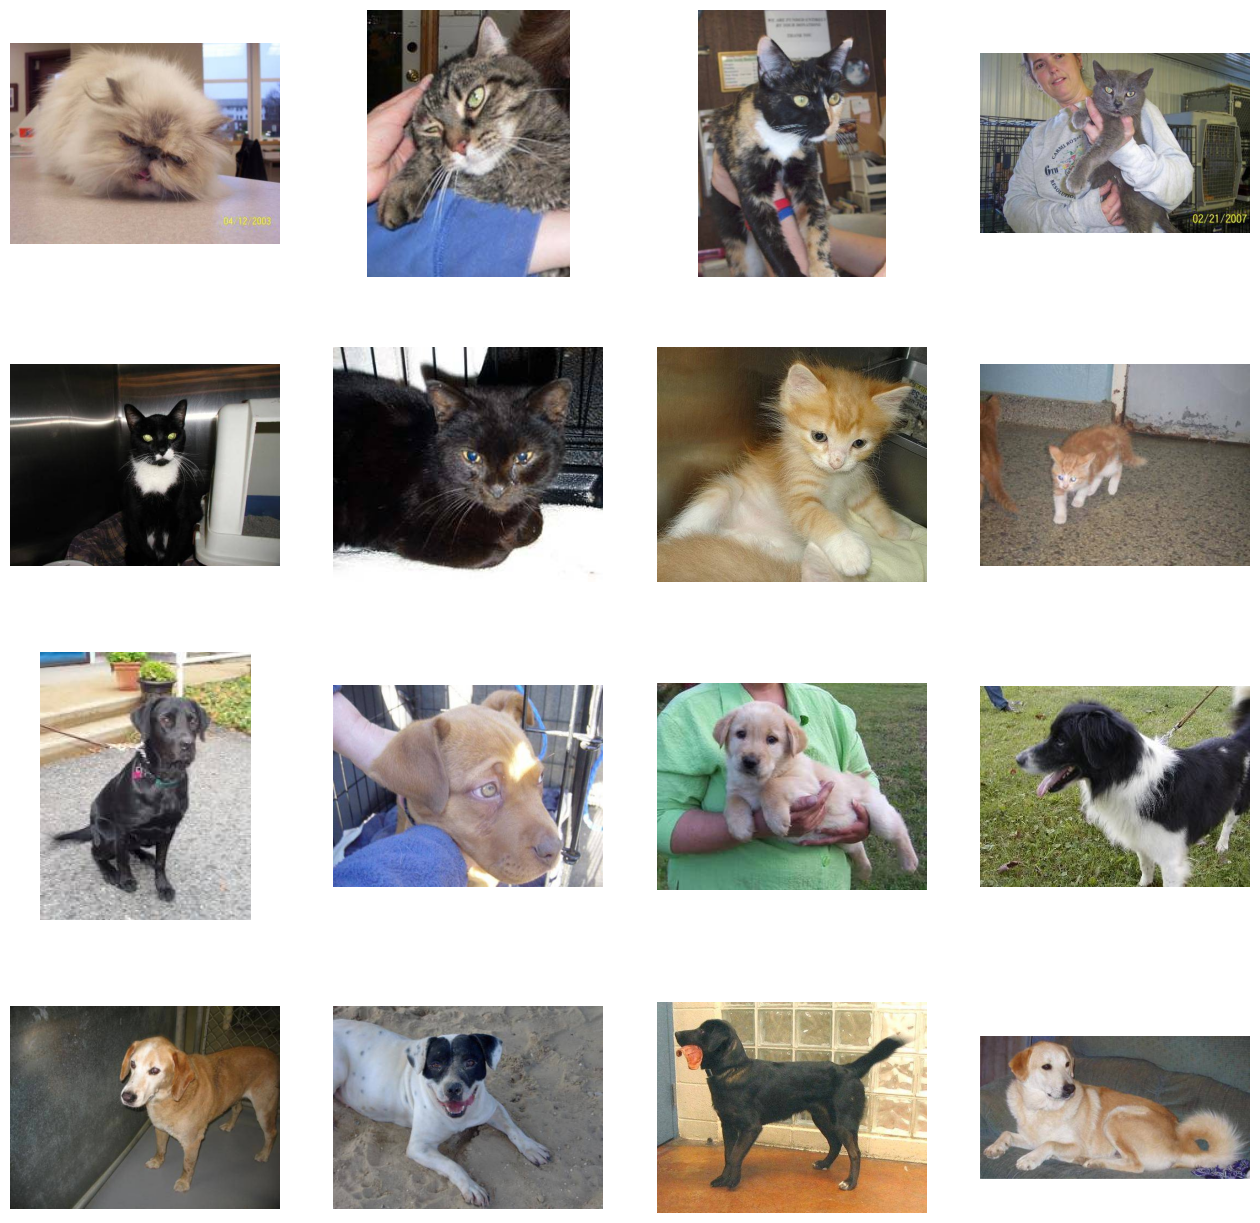

In [12]:
# Display a few example in dataset

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for 4x4 configuration
nrows = 4
ncols = 4

# iteration
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cat_dir, fname)
                for fname in train_cat_file_names[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dog_dir, fname)
                for fname in train_dog_file_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# 3-) Data Augmentation with ImageDataGenerator

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Train Generator
train_generator = train_datagen.flow_from_directory(

    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

# Validation Generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 4-) Build Model

Since the dataset was limited and the performance of the model trained from scratch with CNN was around 55%, I used the VGG16 model pre-trained by Imagenet. (You can test the performance of the model trained from scratch by running the code in the comment line.)
I kept the base layers of this model trained with millions of images fixed and retrained the upper layers with new data for this case.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout

In [36]:
# Load the pre-trained VGG16 model
from tensorflow.keras.applications import VGG16

conv_model = VGG16(weights = "imagenet",
                   include_top = False, # Don't load the last layer (classification) of model
                   input_shape = (150, 150, 3))

# Freeze the layers
conv_model.trainable = False


In [37]:
# Build Model

model = Sequential([
    conv_model,
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5), # Add dropout: randomly disable 50% neurons in each epoch, to avoid overfitting
    Dense(1, activation= "sigmoid")
])

In [ ]:
"""
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Build Model

model = Sequential([
  Conv2D(16, (3,3), activation= 'relu', input_shape= (300,300,3)),
  MaxPooling2D(2,2),
  Conv2D(32, (3,3), activation= 'relu'),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation= 'relu'),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation= 'relu'),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation= 'relu'),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation= 'relu'),
  MaxPooling2D(2,2),
  Flatten(),
  Dense(512, activation = 'relu'),
  Dense(1, activation= "sigmoid")
  ])
"""


# 5-) Compile Model

In [38]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# 6-) Before Training the Model, Calculate number of steps per epoch for train and validation generators

In [46]:
# How many Images do we have in train and validation sets
total_train_images = train_generator.samples
total_val_images = validation_generator.samples

print("Total Train Images:",total_train_images)
print("Total Validation Images:",total_val_images)

# Calculate number of steps
steps_per_epoch = total_train_images // train_generator.batch_size
validation_steps = total_val_images // validation_generator.batch_size

print("Steps per epoch:",steps_per_epoch)
print("Validation steps:",validation_steps)

Total Train Images: 2000
Total Validation Images: 1000
Steps per epoch: 100
Validation steps: 50


# 7-) Avoid Overfitting And Improve The Training Process
- Dropout (Added in Model building path)
- EarlyStopping (as a Callback)
- ReduceLROnPlateau (as a Callback)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [47]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# 8-) Train The Model

In [48]:
# Train
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=8,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 585s 6s/step - accuracy: 0.9233 - loss: 0.2091 - val_accuracy: 0.9000 - val_loss: 0.2822 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9187 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 587s 6s/step - accuracy: 0.9281 - loss: 0.1673 - val_accuracy: 0.8750 - val_loss: 0.2820 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 470ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8625 - val_loss: 0.2785 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.9426 - loss: 0.1471 - val_accuracy: 0.8562 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9062 - val_loss: 0.2096 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━

# 9-) Evaulate with Visualizations

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğunu çizdirin
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)  # Epoch numaralarını oluşturun

plt.figure(figsize=(12, 6))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
